# Generating 3D Geometries from 2D RyR placements

These scripts are intended to take binary images of RyR locations in a 2D plane, and create a 3D volumetric mesh based on this information. The resulting geometry is intended to be phenomenologically similar in function, but not inteded to be physiologically accurate - we there model the nSR as straight columns in the z-direction.

From the original 2D binary array of RyR locations, we produce four two-dimensional arrays given in 12 nm resolution:
    1. RyR
    2. jSR
    3. nSR columns
    4. t-tubules

The following examples show how these arrays are made

# Geometry Utils

Functionality for reading RyR data from `.ppm`-files and manipulating the 2D arrays is located in `geometry_utils.py`

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import geometry_util as gu

In [2]:
def plot(array, title='', show=True, **kwargs):
    plt.imshow(array, origin='lower', interpolation='none', cmap='Greys_r', **kwargs)
    plt.title(title)
    plt.xticks(())
    plt.yticks(())
    if show:
        plt.show()

##### Read .ppm file into numpy array

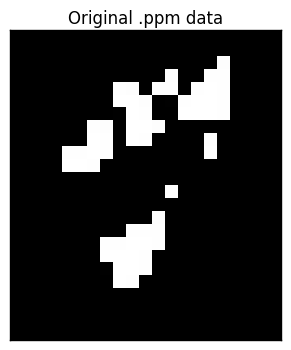

(24, 21)


In [3]:
original = gu.read_ppm('img/7_sub')
plot(original, 'Original .ppm data')
print original.shape

This is the raw data of RyR locations, with each pixel in this dataset represents $36\times36$ nm. Note that the shape of the array is irregular. To change the array to represent an area of $2\times2$ μm we first trim down to the bounding box of the data and then pad with zeros on all sides to get to the correct size, effectively centering the data.

##### Trim down to bounding box
* Note that the data is transposed to ensure that the x-axis is longer for aesthetic reasons
    * Can be avoided with the kwarg `flip=False`

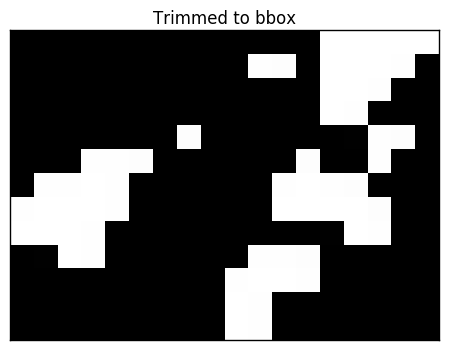

In [4]:
bbox = gu.trim_to_bbox(original)
plot(bbox, 'Trimmed to bbox')

##### Pad image with zeros to specified size
We choose dimensions of $56\times 56$ pixels because $56\times 36 {\rm\ nm} = 2.016$ μm

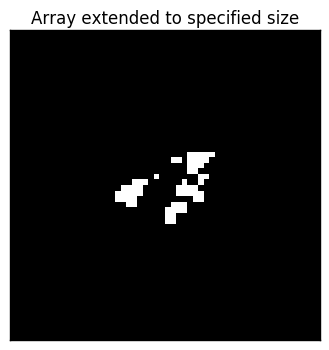

In [5]:
ryr = gu.pad_array(bbox, (56, 56))
plot(ryr, title='Array extended to specified size')

### Create jSR data from RyR

As RyRs are found in the jSR, we assume the jSR to be located surrounding the RyRs. The jSR is therefore created by padding with layers of jSR aronud the RyR. The numbers of layers to pad will strongly affect the simulations as there will both be more jSR, but it will also decide which RyR's are strongly connected and not

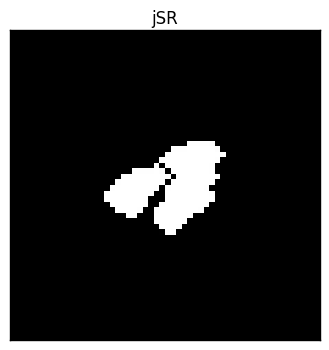

In [6]:
jsr = gu.create_jsr(ryr, 2) # Pad with 2 layers
plot(jsr, 'jSR')

### Refine RyR and jSR arrays

The raw data were given with a resolution of 36 nm, but both the size of a RyR and the width of the dyadic cleft are smaller, at 12 nm, we therefore refine the resolution of our arrays. This is done differently for the RyR and jSR.

Subdviding each pixel into $3\times 3$ pixels, the RyR array is refined by placing the RyR in the centermost of the smaller pixels. This means that all RyRs will lie in regular grids, with a distance of 36 nm between them. For the jSR we fill in all the subpixels, for corners

##### Example refinement

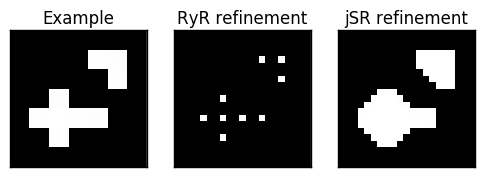

In [7]:
original = np.zeros((7, 7))
original[1:-3, 2] = 1
original[2, 1:-2] = 1
original[5, 4:6] = 1
original[4, 5] = 1

fig, axs = plt.subplots(nrows=1, ncols=3)
plt.sca(axs[0]); plot(original, title='Example', show=False)
plt.sca(axs[1]); plot(gu.refine_ryr(original, 3), show=False, title='RyR refinement')
plt.sca(axs[2]); plot(gu.refine_jsr(original, 3), show=False, title='jSR refinement')
plt.show()

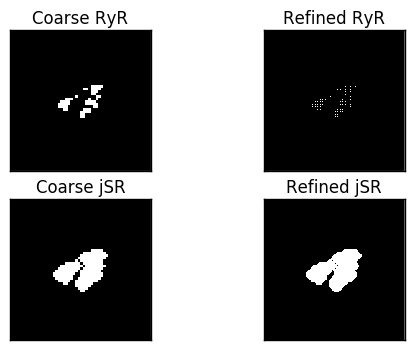

In [8]:
fig, axs = plt.subplots(nrows=2, ncols=2)

plt.sca(axs[0,0])
plot(ryr, show=False, title='Coarse RyR')
ryr = gu.refine_ryr(ryr, 3)
plt.sca(axs[0,1])
plot(ryr, show=False, title='Refined RyR')

plt.sca(axs[1,0])
plot(jsr, show=False, title='Coarse jSR')
jsr = gu.refine_jsr(jsr, 3)
plt.sca(axs[1,1])
plot(jsr, show=False, title='Refined jSR')
plt.show()

##### Plot Combined RyR and jSR

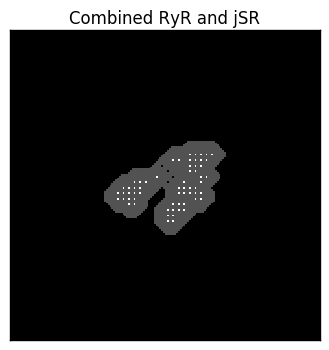

In [9]:
combined = jsr + 3*ryr
plot(jsr + 3*ryr, 'Combined RyR and jSR')

#### Creating nSR columns

We create nSR as $36\times36$ nm columns surrounding each individual RyR

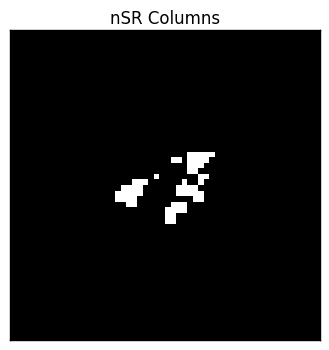

In [10]:
nsr = gu.create_nsr(ryr, width=3)
plot(nsr, title='nSR Columns')

##### Plot RyR, jSR and nSR together

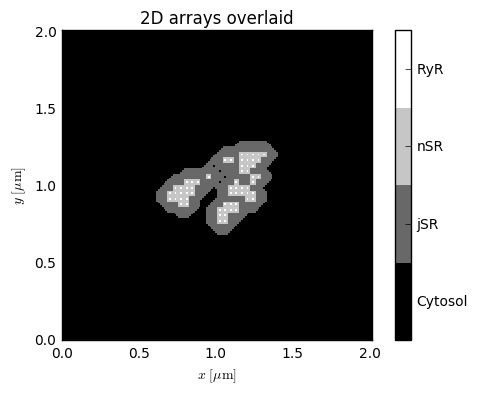

In [11]:
combined = jsr.astype(np.uint8)
combined += nsr
combined += ryr

cmap = plt.get_cmap('Greys_r', 4)
gu.plot_array(combined, psize=12e-3, cmap=cmap,
              title='2D arrays overlaid', vmin=0, vmax=4)

cbar = plt.colorbar(ticks=np.arange(0.5, 5))
cbar.ax.set_yticklabels(['Cytosol', 'jSR', 'nSR', 'RyR'])
plt.show()

##### Save combined 2D plot as pdf

In [12]:
gu.save_combined_2D_pdf("P2_7_sub", jsr, nsr, ryr)

### Creating 3D geometry

We have now created the RyR, jSR and nSR 2D arrays of the same size and resolution $12\times12$ nm. We let the t-tubule array also be represented by the jSR, meaning it is found at the opposite side of the cleft wherever jSR is found

* The 3D geometry is by extending the arrays in the z-direction by the following process
    1. The cleft is placed at the center z index
    2. The jSR is placed on one side of the cleft and extended to a given thickness
    3. The corner layers of the jSR are smoothed
    4. The t-tubule voxels are placed on the other side of the cleft
    5. nSR columns are added atop the jSR and extended to a given height
    6. A nSR roof is added to the top of the column, this is simply the bounding box of all columns
    7. All other voxels are marked as cytosol
    8. Boundary markers are added to aid later simulation
    9. Both geometry and boundary information is saved to a h5 file

All this is performed by the function
    * generate_cru_geometry_file
 
To perform all the steps from `.ppm`-file to `.h5` geometry file, use
    * generate_cru_geometry_file

In [13]:
import generate_cru_geometry_file as gcgf

gcgf.generate_cru_geometry_file(ryr, jsr, nsr, 
                                nz=3*56, # ~2 um
                                cleft_size=1, 
                                jsr_thickness=3, 
                                double=True, 
                                basename='geometries/example')

## Visualizing the geometry

To visualize the geometry, you can use the `GeometryVisualizer` class from `visualize_geomtry.py`. This can also be used via the terminal and controlled via command line arguments.

##### Command-line arguments for geometry visualization

In [14]:
%run visualize_geometry.py -h

usage: visualize_geometry.py geometry_file [options]

Visualize a 3D geometry.

positional arguments:
  geometry_file         h5 geometry file to visualize

optional arguments:
  -h, --help            show this help message and exit
  --domains [d [d ...]]
                        sequence of visible domains, use ids from [0, 4]
  --boundaries [b [b ...]]
                        sequence of visibile boundaries, use names
  --frame               Draw a bounding box of entire geometry
  --no-frame            Do not draw bounding box for entire geometry


In [15]:
%run visualize_geometry.py geometries/example_double.h5 --d 1 2 3 4 --frame